In [1]:
import pybaseball as pb
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as ss
import matplotlib.ticker
import os

In [2]:
pb.cache.enable()

In [ ]:
#The following code is to download the data and write a CSV, so that the data need not be downloaded again.  This code can be left out.

In [ ]:
#batters_df_1=pb.batting_stats(start_season = 1920, end_season = 1980, stat_columns = ['Name', 'Age', 'Season', 'WAR', 'OPS'], qual=200)

In [ ]:
#batters_df_2=pb.batting_stats(start_season = 1980, end_season = 2024, stat_columns = ['Name', 'Age', 'Season', 'WAR', 'OPS'], qual=200)

In [ ]:
#batters_df = pd.concat([batters_df_1, batters_df_2]).drop_duplicates()

In [ ]:
#batters_df.to_csv('batters.csv')

In [7]:
batters_df = pd.read_csv('batters.csv')

In [41]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [42]:
batter_model = make_pipeline(PolynomialFeatures(degree=2, include_bias=False), LinearRegression())

In [43]:
batter_model.fit(batters_df[['Age']], batters_df['WAR'])

,steps,"[('polynomialfeatures', ...), ('linearregression', ...)]"
,transform_input,None
,memory,None
,verbose,False
,degree,2
,interaction_only,False
,include_bias,False
,order,'C'
,fit_intercept,True
,copy_X,True
,tol,1e-06


In [44]:
batter_steps = batter_model.named_steps['linearregression']

In [49]:
f'(Our first estimate at an aging curve for batters gives the model:  WAR = {batter_steps.intercept_} + {batter_steps.coef_[0]}*Age + {batter_steps.coef_[1]}*Age^2)'

'(Our first estimate at an aging curve for batters gives the model:  WAR = -2.4047011577646513 + 0.3038444804020386*Age + -0.005482156587131644*Age^2)'

c:\Users\dylan\anaconda3\envs\baseball_data\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


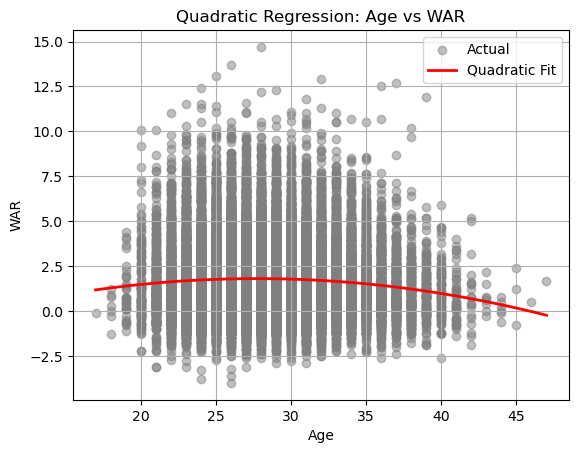

In [55]:
ages = np.linspace(batters_df['Age'].min(), batters_df['Age'].max(), 100).reshape(-1, 1)
war_pred = batter_model.predict(ages)

plt.scatter(batters_df['Age'], batters_df['WAR'], color='gray', alpha=0.5, label='Actual')
plt.plot(ages, war_pred, color='red', linewidth=2, label='Quadratic Fit')
plt.xlabel('Age')
plt.ylabel('WAR')
plt.title('Quadratic Regression: Age vs WAR')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#This is obviously much too general, we have to try to account for player ability.  We can start with fixed-effects model

In [50]:
from statsmodels.formula.api import ols

In [51]:
batters_df['Age2'] = batters_df['Age']**2

In [61]:
#batter_fixedeffects = ols('WAR~Age+Age2+C(IDfg)', data=batters_df).fit()

#This doesn't work without first removing players with careers which are too short.
batters_df_fe = batters_df.groupby('IDfg').filter(lambda x: len(x) > 3)
batter_fixedeffects = ols('WAR~Age+Age2+C(IDfg)', data=batters_df_fe).fit()

In [ ]:
batter_fixedeffects.params[['Intercept','Age', 'Age2']]

Intercept   -13.019066
Age           1.147563
Age2         -0.021482
dtype: float64

In [76]:
batter_fixedeffects.pvalues[['Age','Age2']]

Age     5.229091e-292
Age2     0.000000e+00
dtype: float64

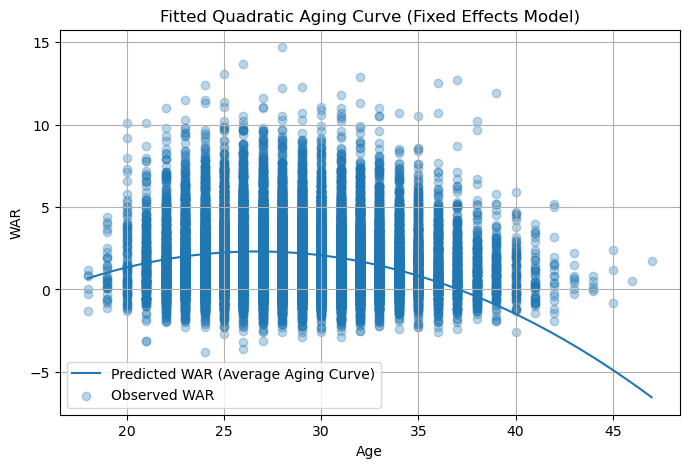

In [77]:
intercept = batter_fixedeffects.params['Intercept']
coef_age = batter_fixedeffects.params['Age']
coef_age2 = batter_fixedeffects.params['Age2']
age_range = np.linspace(batters_df_fe['Age'].min(), batters_df_fe['Age'].max(), 100)
predicted_war = intercept + coef_age * age_range + coef_age2 * (age_range ** 2)
plt.figure(figsize=(8,5))
plt.plot(age_range, predicted_war, label='Predicted WAR (Average Aging Curve)')
plt.scatter(batters_df_fe['Age'], batters_df_fe['WAR'], alpha=0.3, label='Observed WAR')
plt.xlabel('Age')
plt.ylabel('WAR')
plt.title('Fitted Quadratic Aging Curve (Fixed Effects Model)')
plt.legend()
plt.grid(True)
plt.show()

In [79]:
print([batter_fixedeffects.aic,batter_fixedeffects.bic])

[np.float64(88226.56303573455), np.float64(110317.98132635477)]


In [ ]:
#We can do better and lose less data with a random/mixed effects model

In [ ]:
from statsmodels.formula.api import mixedlm

In [83]:
batter_mixed = mixedlm("WAR ~ Age + Age2", data=batters_df, groups=batters_df["IDfg"])

In [87]:
batter_mixed_results = batter_mixed.fit(reml=False)

In [88]:
batter_mixed_results.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
          Mixed Linear Model Regression Results
=========================================================
Model:            MixedLM Dependent Variable: WAR        
No. Observations: 27131   Method:             ML         
No. Groups:       4912    Scale:              2.1895     
Min. group size:  1       Log-Likelihood:     -52549.4625
Max. group size:  24      Converged:          Yes        
Mean group size:  5.5                                    
---------------------------------------------------------
            Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
---------------------------------------------------------
Intercept  -12.063    0.414 -29.107 0.000 -12.876 -11.251
Age          1.009    0.028  35.444 0.000   0.953   1.065
Age2        -0.019    0.000 -38.618 0.000  -0.020  -0.018
Group Var    1.552    0.030                              
=========================================================

"""

In [89]:
print(batter_mixed_results.aic,batter_mixed_results.bic)

105108.92498594127 105149.96714726396


In [ ]:
#questionable whether or not this model is better, but it allows us to use all players.

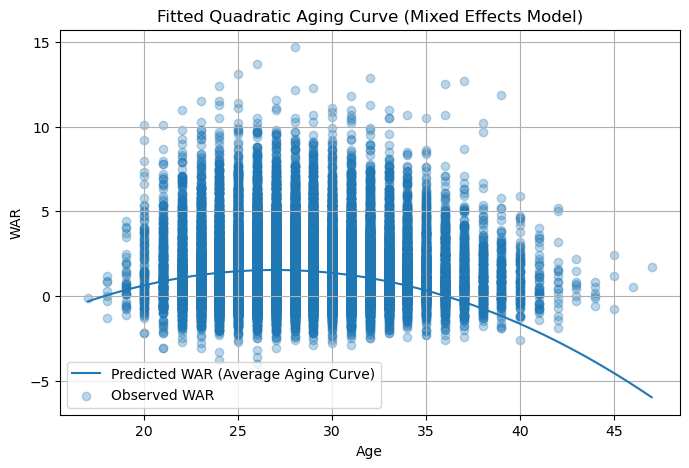

In [90]:
intercept = batter_mixed_results.params['Intercept']
coef_age = batter_mixed_results.params['Age']
coef_age2 = batter_mixed_results.params['Age2']
age_range = np.linspace(batters_df['Age'].min(), batters_df['Age'].max(), 100)
predicted_war = intercept + coef_age * age_range + coef_age2 * (age_range ** 2)
plt.figure(figsize=(8,5))
plt.plot(age_range, predicted_war, label='Predicted WAR (Average Aging Curve)')
plt.scatter(batters_df['Age'], batters_df['WAR'], alpha=0.3, label='Observed WAR')
plt.xlabel('Age')
plt.ylabel('WAR')
plt.title('Fitted Quadratic Aging Curve (Mixed Effects Model)')
plt.legend()
plt.grid(True)
plt.show()

In [91]:
#using this model to project

latest_ages = batters_df.groupby('IDfg')['Age'].max().reset_index()
latest_ages.rename(columns={'Age': 'CurrentAge'}, inplace=True)

n_years = 3
projection_rows = []
projection_rows = []

for _, row in latest_ages.iterrows():
    player_id = row['IDfg']
    current_age = row['CurrentAge']
    
    for i in range(1, n_years + 1):
        future_age = current_age + i
        projection_rows.append({
            'IDfg': player_id,
            'Age': future_age,
            'Age2': future_age ** 2,
            'YearFromNow': i
        })

future_batters_df = pd.DataFrame(projection_rows)

random_effects = batter_mixed_results.random_effects
fe = batter_mixed_results.fe_params
future_batters_df['FixedPrediction'] = (
    fe['Intercept'] +
    fe['Age'] * future_batters_df['Age'] +
    fe['Age2'] * future_batters_df['Age2']
)
future_batters_df['RandomEffect'] = future_batters_df['IDfg'].map(lambda pid: random_effects.get(pid, {'Group': 0})['Group'])
future_batters_df['Predicted_WAR'] = future_batters_df['FixedPrediction'] + future_batters_df['RandomEffect']

In [100]:
player_names = batters_df[['IDfg', 'Name']].drop_duplicates()
result = future_batters_df[['IDfg', 'Age', 'YearFromNow', 'Predicted_WAR']]

result_with_names = result.merge(player_names, on='IDfg', how='left')
latest_season = batters_df.groupby('IDfg')['Season'].max().reset_index()
latest_season.rename(columns={'Season': 'LastSeason'}, inplace=True)
result_with_names = result_with_names.merge(latest_season, on='IDfg', how='left')
result_with_names['Season'] = result_with_names['LastSeason'] + result_with_names['YearFromNow']
result_with_names = result_with_names[result_with_names['LastSeason']>2023]
print(result_with_names.head(10))

      IDfg  Age  YearFromNow  Predicted_WAR            Name  LastSeason  \
1899  2136   37            1       0.194359   David Peralta        2024   
1900  2136   38            2      -0.200358   David Peralta        2024   
1901  2136   39            3      -0.632503   David Peralta        2024   
1980  2396   39            1      -0.215151  Carlos Santana        2024   
1981  2396   40            2      -0.684723  Carlos Santana        2024   
1982  2396   41            3      -1.191722  Carlos Santana        2024   
2076  2967   37            1       0.902442      Tommy Pham        2024   
2077  2967   38            2       0.507725      Tommy Pham        2024   
2078  2967   39            3       0.075580      Tommy Pham        2024   
2208  3473   35            1       1.712175   Anthony Rizzo        2024   

      Season  
1899    2025  
1900    2026  
1901    2027  
1980    2025  
1981    2026  
1982    2027  
2076    2025  
2077    2026  
2078    2027  
2208    2025  


In [104]:
war_sum_by_player = (
    result_with_names
    .groupby(['IDfg', 'Name'])['Predicted_WAR']
    .sum()
    .reset_index()
    .rename(columns={'Predicted_WAR': 'Total_Projected_WAR'})
)

In [106]:
war_sum_by_player.sort_values('Total_Projected_WAR', ascending=False)

,IDfg,Name,Total_Projected_WAR
103,15640,Aaron Judge,16.359190
213,20123,Juan Soto,15.886303
302,25764,Bobby Witt Jr.,14.722439
57,12916,Francisco Lindor,13.913213
318,26289,Gunnar Henderson,13.304747
...,...,...,...
16,7859,Charlie Blackmon,-1.366059
1,2396,Carlos Santana,-2.091597
43,11680,Elias Diaz,-2.231201
17,8623,Donovan Solano,-2.262071


In [110]:
war_sum_by_player['projected_value'] = 8*war_sum_by_player['Total_Projected_WAR']
war_sum_by_player.sort_values('projected_value', ascending=False)

,IDfg,Name,Total_Projected_WAR,projected_value
103,15640,Aaron Judge,16.359190,130.873518
213,20123,Juan Soto,15.886303,127.090422
302,25764,Bobby Witt Jr.,14.722439,117.779515
57,12916,Francisco Lindor,13.913213,111.305705
318,26289,Gunnar Henderson,13.304747,106.437975
...,...,...,...,...
16,7859,Charlie Blackmon,-1.366059,-10.928473
1,2396,Carlos Santana,-2.091597,-16.732777
43,11680,Elias Diaz,-2.231201,-17.849606
17,8623,Donovan Solano,-2.262071,-18.096565


,yearID,lgID,teamID,franchID,teamIDfg,teamIDBR,teamIDretro


In [ ]:
pitchers_df = pb.pitching_stats(start_season = 1920, end_season = 2024, stat_columns = ['Name', 'Age', 'Season', 'WAR','W'], qual=50)